In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
sessions <- read_csv("data/sessions.csv") |>
                  mutate(start_time = dmy_hm(start_time),
                  end_time = dmy_hm(end_time),
                  start_time_date = as.Date(start_time),
                  end_time_date = as.Date(end_time),
                  start_time_min = hour(start_time) * 60 + minute(start_time),
                  end_time_min = hour(end_time) * 60 + minute(end_time),
                  start_time = format(start_time, "%H:%M:%S"),
                  end_time = format(end_time , "%H:%M:%S"),
                  player = row_number())
           
sessions




Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time,start_time_date,end_time_date,start_time_min,end_time_min,player
<chr>,<chr>,<chr>,<dbl>,<dbl>,<date>,<date>,<dbl>,<dbl>,<int>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,18:12:00,18:24:00,1.71977e+12,1.71977e+12,2024-06-30,2024-06-30,1092,1104,1
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,23:33:00,23:46:00,1.71867e+12,1.71867e+12,2024-06-17,2024-06-17,1413,1426,2
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,17:34:00,17:57:00,1.72193e+12,1.72193e+12,2024-07-25,2024-07-25,1054,1077,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15:36:00,15:57:00,1.72218e+12,1.72218e+12,2024-07-28,2024-07-28,936,957,1533
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,06:15:00,06:22:00,1.72189e+12,1.72189e+12,2024-07-25,2024-07-25,375,382,1534
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,02:26:00,02:45:00,1.71617e+12,1.71617e+12,2024-05-20,2024-05-20,146,165,1535


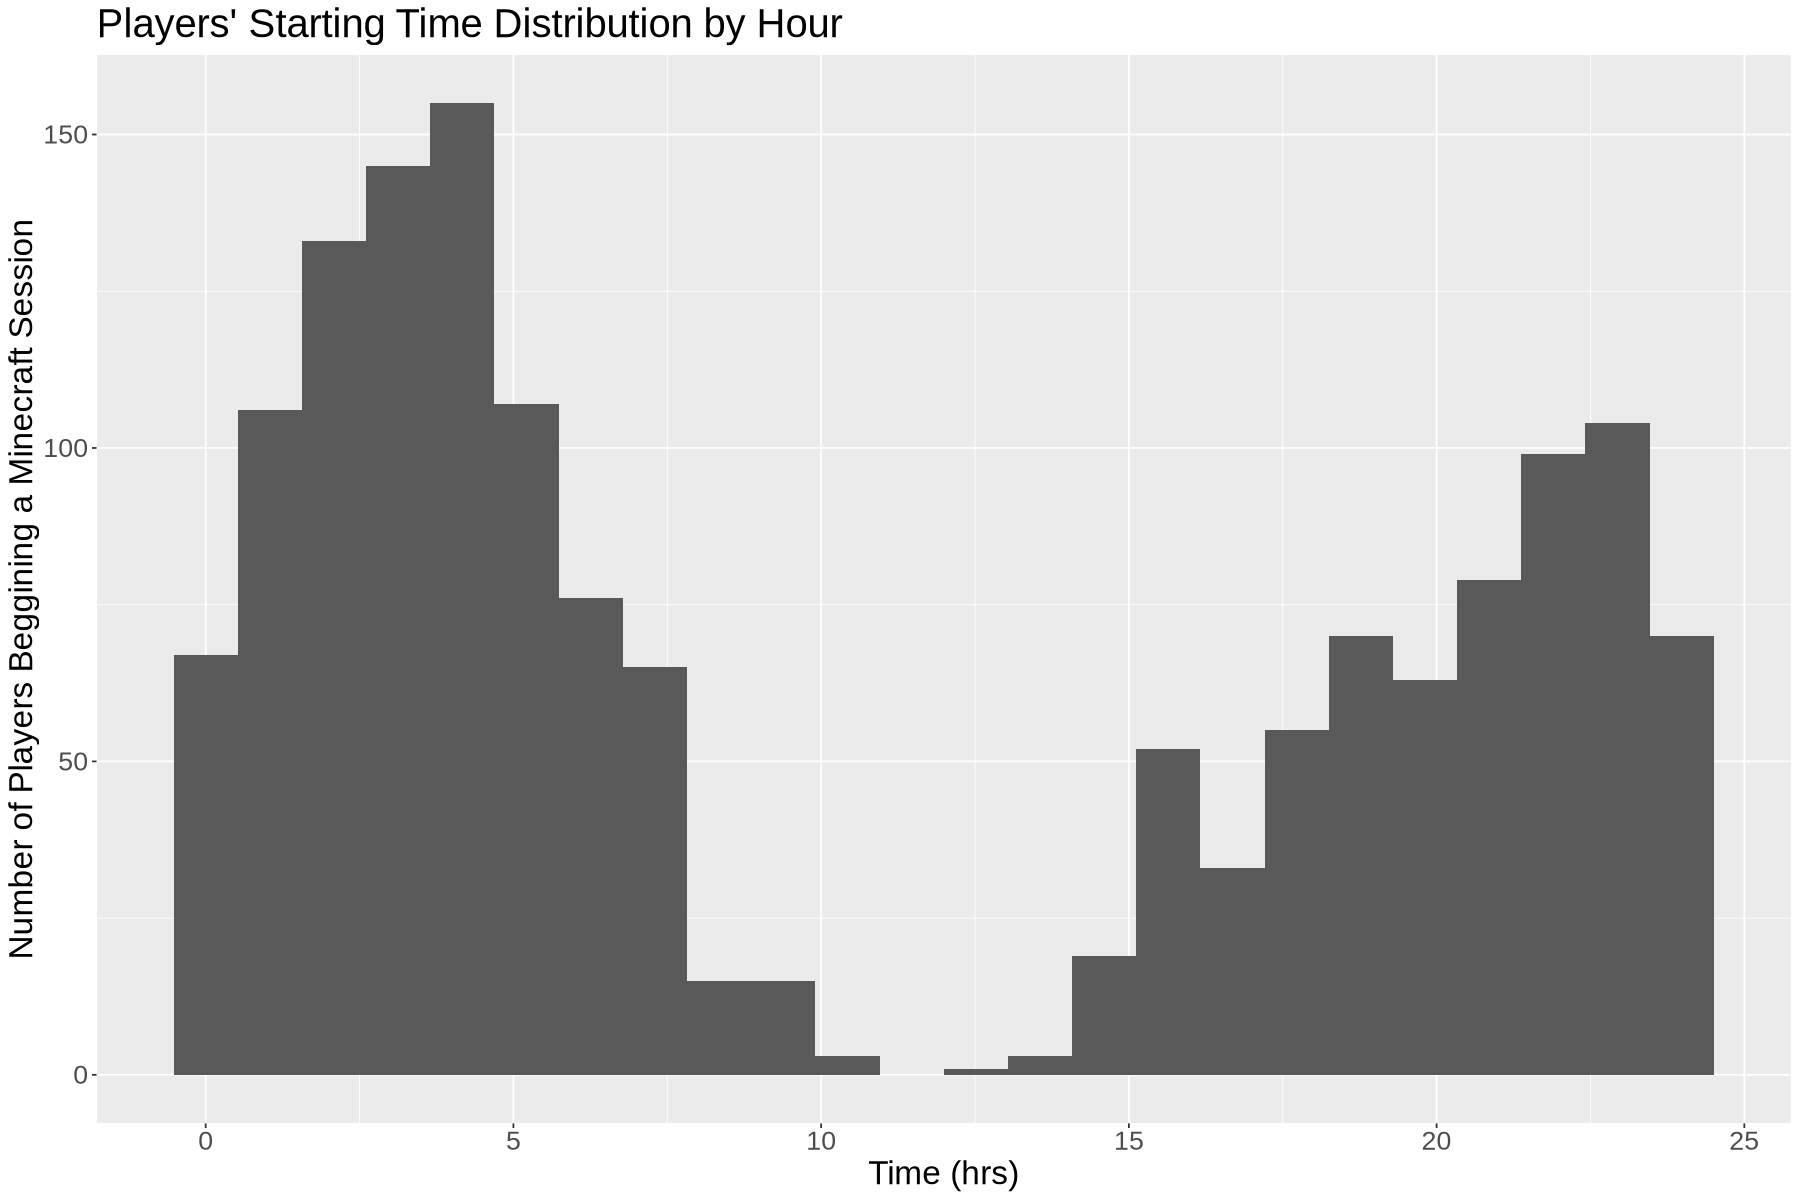

In [3]:
options(repr.plot.width = 15, repr.plot.height = 10)

start_time_distribution <- sessions |>
                 ggplot (aes ((x = start_time_min)/60)) +
                 geom_histogram(bins = 24)+
                 labs(x = "Time (hrs)", y = "Number of Players Beggining a Minecraft Session",
                      title = "Players' Starting Time Distribution by Hour") +
                 theme(text = element_text (size = 20))

start_time_distribution

start_time_min,players
<dbl>,<int>
0,30
1,66
2,58
⋮,⋮
46,56
47,59
48,29


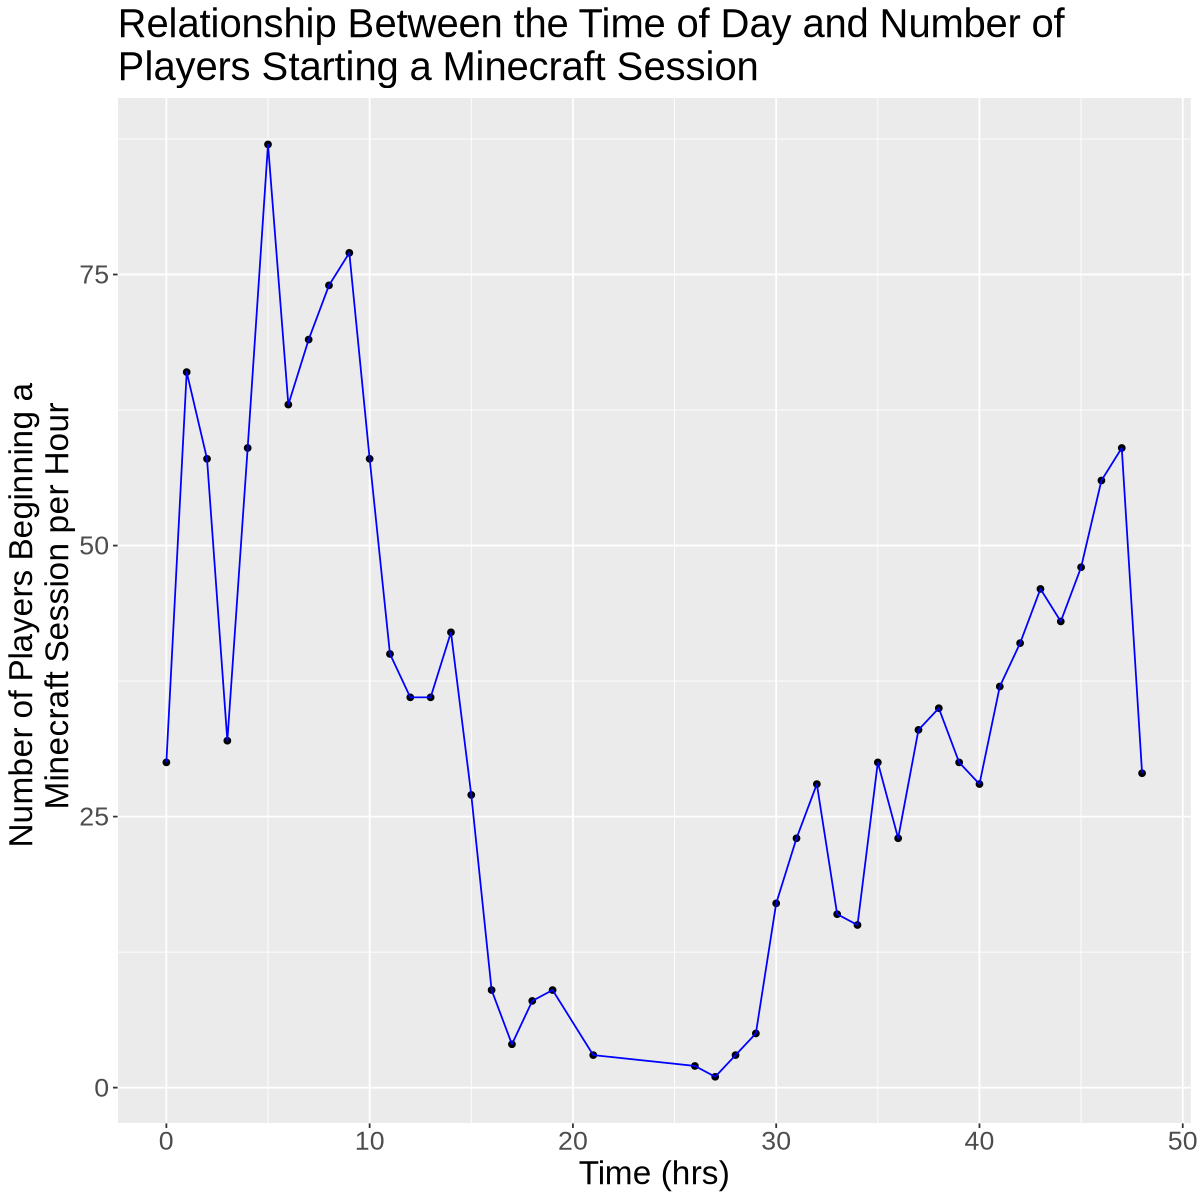

In [17]:
options(repr.plot.width = 10, repr.plot.height = 10)
sessions_peak_start <- sessions |>
                  mutate (start_time_min = round((start_time_min / 30), 0)) |>
                  group_by(start_time_min)|>
                  summarize(players = n())

sessions_peak_start

sessions_peak_start_plot <- sessions_peak_start |>
                     ggplot(aes(x = start_time_min , y = players))+
                     geom_point() +
                     geom_line(color = "blue") +
                     labs(x = "Time (hrs)", y = "Number of Players Beginning a \n Minecraft Session per Hour",
                         title = "Relationship Between the Time of Day and Number of \nPlayers Starting a Minecraft Session") +
                      theme(text = element_text (size = 20)) 
                      
sessions_peak_start_plot 

In [18]:
sessions_split <- initial_split(sessions_peak_start, prop = 0.75, strata = start_time_min)
sessions_train <- training(sessions_split)
sessions_test <- testing(sessions_split)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 2 breaks instead.”


In [30]:
sessions_recipe <- recipe(players ~ start_time_min, data = sessions_train) |>
                   step_scale(all_predictors()) |>
                    step_center(all_predictors())
sessions_recipe

sessions_spec <-  nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
                  set_engine("kknn") |>
                  set_mode("regression")
sessions_spec

sessions_vfold <- vfold_cv(sessions_train, v = 5, strata = players)

sessions_wkflw <-  workflow() |> 
                   add_recipe(sessions_recipe)|>
                   add_model(sessions_spec)

sessions_wkflw
              
                   



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 1



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 1 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [31]:
gridvals <- tibble(neighbors = seq(from = 1, to = 44))

sessions_results <- sessions_wkflw |>
                     tune_grid(resamples = sessions_vfold) |>
                     collect_metrics()|>
                     filter(.metric == "rmse")
sessions_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,rmse,standard,10.83978,5,3.567686,Preprocessor1_Model01
4,rmse,standard,12.88654,5,2.845252,Preprocessor1_Model02
5,rmse,standard,14.20925,5,1.925256,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,rmse,standard,17.87088,5,0.9027389,Preprocessor1_Model08
13,rmse,standard,18.81259,5,0.9742396,Preprocessor1_Model09
15,rmse,standard,20.19856,5,1.4380499,Preprocessor1_Model10


In [32]:
sessions_min <-  sessions_results |>
                 filter(mean == min(mean))

sessions_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,rmse,standard,10.83978,5,3.567686,Preprocessor1_Model01


In [34]:
kmin <-  sessions_min |>
          pull(neighbors)

sessions_spec2 <-  nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
                   set_engine("kknn") |>
                   set_mode("regression")

sessions_spec2

sessions_fit <-  workflow() |>
                 add_recipe(sessions_recipe)|>
                 add_model(sessions_spec2) |>
                 fit(data = sessions_train)

 sessions_fit   



K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = kmin
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2L,     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 7.734375
Minimal mean squared error: 120.1172
Best kernel: rectangular
Best k: 2

In [38]:
sessions_predictions <-  sessions_fit |>
                     predict(sessions_test)|>
                     bind_cols(sessions_test)
sessions_predictions

sessions_summary <- sessions_predictions|>
                    metrics(truth = players, estimate =.pred) |>
                     filter(.metric == "rmse")

.pred,start_time_min,players
<dbl>,<dbl>,<int>
49.0,2,58
45.5,5,87
71.5,6,63
⋮,⋮,⋮
32.5,37,33
47.0,44,43
57.5,48,29


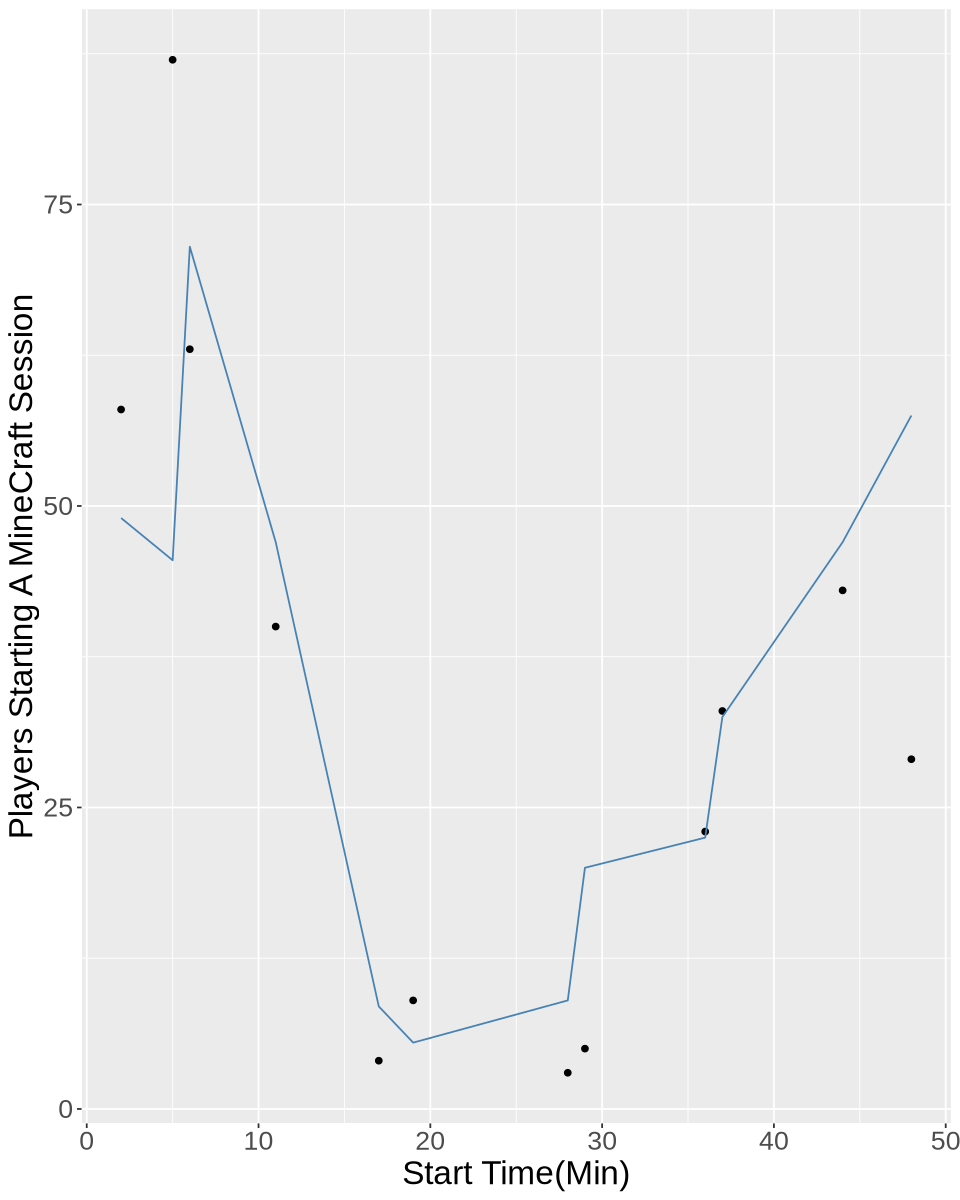

In [49]:
options(repr.plot.width = 8 , repr.plot.height = 10)
sessions_prediction_plot <-  sessions_predictions |>
                             ggplot(aes(x = start_time_min, y = players)) +
                             geom_point() +
                             geom_line(aes(x = start_time_min, y = .pred), 
                                      color = "steelblue") +
                             xlab("Start Time(Min)") +
                             ylab("Players Starting A MineCraft Session") +
                             theme(text = element_text(size = 20))

sessions_prediction_plot 
